We will need to analyse the data using seaborn and matplotlib to visualise some main areas.
    -missing data
    -duplicates
    -any strange variables and outliers
    -formats of data

we will use these options to visualise the areas we have listed. 
    -visually check the data to see if there are any missing values
    -check the names against eachother to see if there are any duplicates 
    -use a boxplot to check for outliers and to see if the datasets have a squew
    -check the units of the columns are equal 


visual analysis 

we can see that missing data is left blank. this makes our checks for data easy however there are multiple rows that have more then one missing pieces of data these will have to be analised and a descision will have to be made on what to do with these pieces of data.



In [2]:
#main imports of the general modules
import xlsxwriter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:

top_header = [ 'Age', 'Gender', 'Diagnosis', 'Refractive_Defect', 'Phakic/Pseudophakic', 'IOP', 'Pachymetry', 'Axial_Length', 'VF_MD' ]
sub_header = [ 'ID', 'Age', 'Gender', 'Diagnosis', 'dioptre_1', 'dioptre_2', 'astigmatism', 'Phakic/Pseudophakic', 'Pneumatic', 'Perkins', 'Pachymetry', 'Axial_Length', 'VF_MD' ]  

workbook = xlsxwriter.Workbook('od.xlsx', {'nan_inf_to_errors': True})
worksheet = workbook.add_worksheet('Sheet1')


header_format = workbook.add_format({'bold': True, "align": "center", "border" : 1, "border_color" : "#000000"})
col_idx = 1  # manually keeping track of the index for merging reasons

for top_label in top_header:  # Takes care of the combined labels 
    
    match top_label:
        case "Refractive_Defect":
            if col_idx == 4:  # Column index for 'Refractive_Defect' | Merges the Next 3 columns
                worksheet.merge_range(0, col_idx, 0, col_idx + 2, top_label, header_format)
                worksheet.set_column(col_idx+2, col_idx+2, 15)
                col_idx += 3
        case "IOP":  # Column index for 'IOP' | Merges the Next 2 columns
            if col_idx == 8:
                worksheet.merge_range(0, col_idx, 0, col_idx + 1, top_label, header_format)
                worksheet.set_column(col_idx, col_idx, 15)
                col_idx += 2
        case _:
            width = len(top_label)
            if width >= 15:
                worksheet.set_column(col_idx, col_idx, 25)
            elif width >= 9:
                worksheet.set_column(col_idx, col_idx, 20)
            else:
                worksheet.set_column(col_idx, col_idx, 8)

            worksheet.write(0, col_idx, top_label, header_format)
            col_idx += 1
    

for i, sub_label in enumerate(sub_header):
    worksheet.write(1, i, sub_label, header_format)  # writes the normal headers


for row_num, row in od.iterrows():  # iterate over the rows of the DF
    for col_num, value in enumerate(row):  # iterates over the columns of the DF and holds the value
        if pd.isna(value):
            worksheet.write(row_num + 2, col_num, '')
        else:
            worksheet.write(row_num + 2, col_num, value)

workbook.close()



now we will import the datasets 


In [3]:
od1 = pd.read_excel("od1.xlsx")
od2 = pd.read_excel("od2.xlsx")
os = pd.read_excel("os.xlsx")


look at the column ID's and make sure the same variables are used

In [39]:
print(od1.columns)
print(od2.columns)
print(os.columns)

Index(['ID', 'Age', 'Gender', 'Diagnosis', 'dioptre_1', 'dioptre_2',
       'astigmatism', 'Pachymetry'],
      dtype='object')
Index(['Diagnosis', 'dioptre_1', 'dioptre_2', 'astigmatism',
       'Phakic/Pseudophakic', 'Pneumatic', 'Perkins', 'Pachymetry',
       'Axial_Length', 'VF_MD'],
      dtype='object')
Index([   '#038',        34,  'female', 'healthy',       0.5,      -1.0,
            90.0,     599.0,       nan,      19.0,       nan,     23.33,
             nan],
      dtype='object')


let's merge the datasets of od1 and od2 so we can have a functioning dataset with all the columns required


In [32]:
def get_merged_header_ranges(header):
    ranges = []
    current_value = header[0]
    start_col = 0
    
    for col_num in range(1, len(header)):
        if header[col_num] != current_value:
            ranges.append((current_value, start_col, col_num - 1))
            current_value = header[col_num]
            start_col = col_num
            
    ranges.append((current_value, start_col, col_num))
    return ranges


In [35]:
od = pd.merge(od1,od2, how= 'outer', on=['Diagnosis', 'dioptre_1', 'dioptre_2',
       'astigmatism', 'Pachymetry'])
#now we need to add multi level indexing
header = pd.MultiIndex.from_tuples([('', 'ID'), ('Age','Age'),('Gender', 'Gender'), ('Diagnosis', 'Diagnosis'), ('Refractive_Defect', 'dioptre_1'), ('Refractive_Defect', 'dioptre_2'), ('Refractive_Defect', 'astigmatism'), ('Phakic/Pseudophakic', 'Phakic/Pseudophakic'), ('IOP', 'Pneumatic'),('IOP', 'Perkins'), ('Pachymetry','Pachymetry'), ('Axial_Length', 'Axial_Length'), ('VF_MD', 'VF_MD') ])




# Create an Excel file with XlsxWriter as the engine
with pd.ExcelWriter('od.xlsx', engine='xlsxwriter') as writer:
    # Write the DataFrame to the Excel file
    od.to_excel(writer, index=False, sheet_name='Sheet1')
    # Get the xlsxwriter workbook and worksheet objects
    workbook = writer.book
    worksheet = writer.sheets['Sheet1']
    header_format = workbook.add_format({'bold': True, "align": "center", "border" : 1, "border_color" : "#000000"})

    # Apply formatting to the first-level header row
    
    merged_header_ranges = get_merged_header_ranges(header.get_level_values(0))
    for value, start_col, end_col in merged_header_ranges:
        if start_col == end_col:
            worksheet.write(0, start_col, value, header_format)
        else:
            worksheet.merge_range(0, start_col, 0, end_col, value, header_format)

    # Apply formatting to the second-level header row
    for col_num, value in enumerate(header.get_level_values(1)):
        worksheet.write(1, col_num, value, header_format)

    # Set column widths
    worksheet.set_column(0, len(header.get_level_values(1)) - 1, 15)

In [37]:

new_columns = od.iloc[0].to_numpy()
os = os.iloc[1:].reset_index(drop=True)
os.columns = new_columns



In [38]:
print(od.columns)
print(os.columns)

Index(['ID', 'Age', 'Gender', 'Diagnosis', 'dioptre_1', 'dioptre_2',
       'astigmatism', 'Pachymetry', 'Phakic/Pseudophakic', 'Pneumatic',
       'Perkins', 'Axial_Length', 'VF_MD'],
      dtype='object')
Index([   '#038',        34,  'female', 'healthy',       0.5,      -1.0,
            90.0,     599.0,       nan,      19.0,       nan,     23.33,
             nan],
      dtype='object')


now let's make an excel file from this

--------------------------------------------------END OF MERGE SECTION ----------------------------------------------------------

let's remove the duplicates using the drop_duplicates from pandas

In [7]:
od.drop_duplicates(inplace=True)
os.drop_duplicates(inplace=True)


Now let's check the missing data and check for any columns with large amounts missing

--------------------------------------------------------------start of data analysis--------------------------------------------------------

In [8]:
od.describe()
#os.describe()

,Age,dioptre_1,dioptre_2,astigmatism,Pachymetry,Pneumatic,Perkins,Axial_Length,VF_MD
count,244.000000,229.000000,241.000000,240.000000,237.000000,197.000000,64.000000,239.000000,82.000000
mean,60.590164,0.754367,-1.899585,88.837500,538.649789,16.190355,17.765625,23.569289,-4.202683
std,13.080161,2.041237,12.842091,42.017364,41.006920,3.664008,4.073695,1.244765,6.141511
min,15.000000,-6.500000,-200.000000,-1.000000,432.000000,9.000000,8.000000,21.040000,-30.150000
25%,52.000000,-0.250000,-1.500000,70.000000,509.000000,13.000000,14.750000,22.680000,-5.137500
50%,62.000000,0.750000,-1.000000,90.000000,537.000000,16.000000,17.500000,23.430000,-2.390000
75%,69.250000,2.000000,-0.500000,108.000000,565.000000,18.000000,20.000000,24.225000,-0.257500
max,90.000000,6.000000,0.500000,180.000000,661.000000,30.000000,29.000000,28.140000,1.550000


In [9]:

def missing_data_counter(df):
    missing_number = df.isna().sum()
    num_rows = df.shape[0]
    
    for i in df.columns:
        
        print(f"{i}'s percentage of missing values is: {100*(missing_number[i]/num_rows)}")
    print('\n\n')
missing_data_counter(od)
missing_data_counter(os)

    







ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 6.147540983606557
dioptre_2's percentage of missing values is: 1.2295081967213115
astigmatism's percentage of missing values is: 1.639344262295082
Pachymetry's percentage of missing values is: 2.8688524590163933
Phakic/Pseudophakic's percentage of missing values is: 2.0491803278688523
Pneumatic's percentage of missing values is: 19.262295081967213
Perkins's percentage of missing values is: 73.77049180327869
Axial_Length's percentage of missing values is: 2.0491803278688523
VF_MD's percentage of missing values is: 66.39344262295081



Unnamed: 0's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
Refractive_Defect's percentage of missing value

------------------------------------------------------------dealing with strings--------------------------------------------------------------

let's start with the phakic/pseudophakic column and let's convert these strings to discrete values. 1 for 'the eye keeps the lens' and 0 for 'crystaline lens has been removed'

first we need to check the formatting of all the strings and make sure they are the same as either of these variables before we can encode them. lets do this with phakic/pseudophakic first




In [10]:

def check_formatting(df,id,expected_values):
    incorrect_values = []
    for i in df[id]:
        if i not in expected_values:
            incorrect_values.append(i)
    return incorrect_values

check_formatting(od, 'Phakic/Pseudophakic', ['crystalline lens has been removed ', 'the eye keeps the lens'])

[nan, nan, nan, nan, nan]

this shows all the values in the column are correctly formatted and now we can encode these values


In [11]:
def encode_strings(df,id,values):
    #values is a list of tuples where the pairs are string and encoded value
    for i in values:
        df[id].replace(i[0],i[1], inplace=True)
encode_strings(od,'Phakic/Pseudophakic',[('crystalline lens has been removed ',0), ('the eye keeps the lens', 1)])
print(od['Phakic/Pseudophakic'].values)

[nan  1.  0.  0.  0.  0.  0.  0. nan  0.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1. nan  0.  1.  1.  1.  0.  1.
  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  0.  1.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.
  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.
  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.
  0.  0.  0.  1.  0.  1.  1.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.
  1.  0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0. nan  1.  0.  1.  0.  1.
  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  0. nan  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.]


now let's try encode diagnosis we will have to check the formatting first

In [12]:
check_formatting(od,'Diagnosis', ['glaucoma','suspicious', 'healthy'])

[]

In [13]:
encode_strings(od, 'Diagnosis', [('glaucoma',0) ,('suspicious', 1), ('healthy', 2)])
print(od['Diagnosis'].values)

[2 2 2 1 2 0 1 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2
 2 2 1 0 2 2 0 0 1 2 0 2 2 2 2 2 1 2 2 0 2 2 2 1 2 2 1 2 2 2 2 2 0 2 2 2 2
 2 0 2 0 0 2 2 1 2 2 1 1 2 2 0 2 1 0 2 2 2 2 1 2 2 2 0 2 2 2 0 2 2 2 2 0 2
 0 0 2 2 2 2 0 0 2 2 2 0 2 2 2 1 0 2 2 0 1 2 0 2 2 2 0 1 2 0 2 2 0 2 2 0 1
 2 1 0 2 2 2 2 1 1 2 0 2 2 2 0 2 1 2 2 1 2 2 2 2 2 2 0 2 2 1 2 1 1 2 2 2 0
 2 0 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 2 2 0 2 2 2 2 2 0 2 2 0 2 2
 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 1 1 0 1 2]


------------------------------------------------------------------------data visualisation---------------------------------------------------------------

Let's explore the distributions of each dataset and it's columns we will use box plot's and histograms to do this 


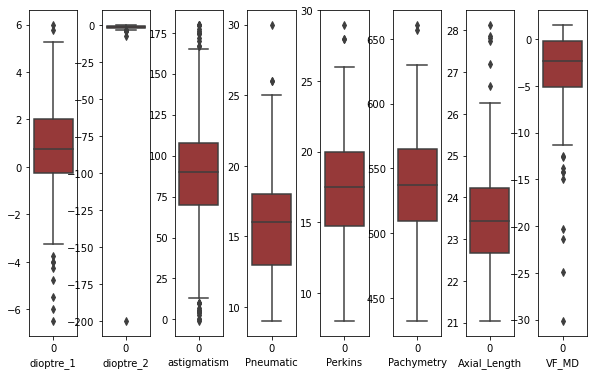

In [14]:
def box_plot_columns(df,ids):
    
    fig, ax = plt.subplots(1, len(ids), figsize=(10, 6))
    plt.subplots_adjust(wspace=0.5) 
    for i in range(len(ids)):
        sns.boxplot(data=df[ids[i]], ax=ax[i],color='brown',)
        ax[i].set_xlabel(ids[i])


box_plot_columns(od, ['dioptre_1', 'dioptre_2','astigmatism', 'Pneumatic', 'Perkins',
       'Pachymetry', 'Axial_Length', 'VF_MD'])

In [15]:
#box_plot_columns(os, ['dioptre_1', 'dioptre_2','astigmatism', 'Pneumatic', 'Perkins',
#       'Pachymetry', 'Axial_Length', 'VF_MD'])

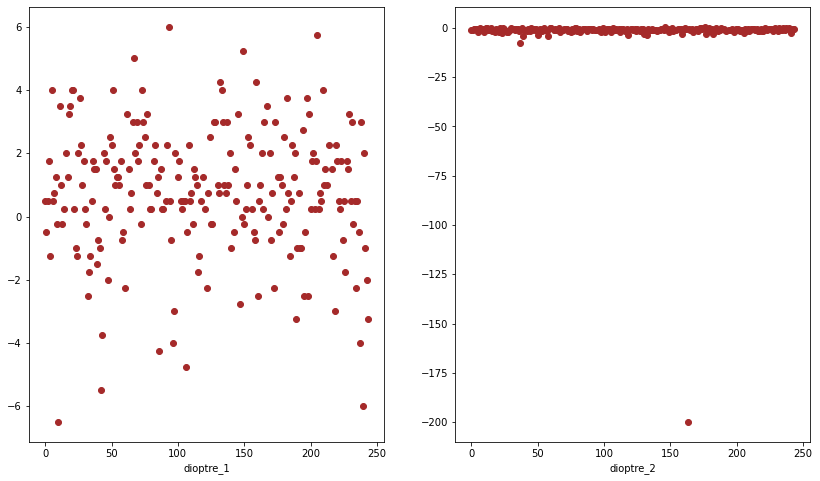

In [16]:
def scatter_plot_columns(df,ids):
    x=np.arange(0,len(df[ids[0]]))
    if(len(ids)==1):
        plt.scatter( x=x ,y=df[ids[0]], color='brown',)
        plt.show()
        return
    fig, ax = plt.subplots(1, len(ids), figsize=(14, 8))
    
    for i in range(len(ids)):
        ax[i].scatter( x=x ,y=df[ids[i]], color='brown',)
        ax[i].set_xlabel(ids[i])


scatter_plot_columns(od, ['dioptre_1','dioptre_2'])

#scatter_plot_columns(os, ['dioptre_1','dioptre_2'])

this value of -200 in dioptre_2 is a clear outlier and will be removed now so the data analysis can be done with more accuracy

In [17]:
od['dioptre_2'].replace(-200, np.nan, inplace=True)

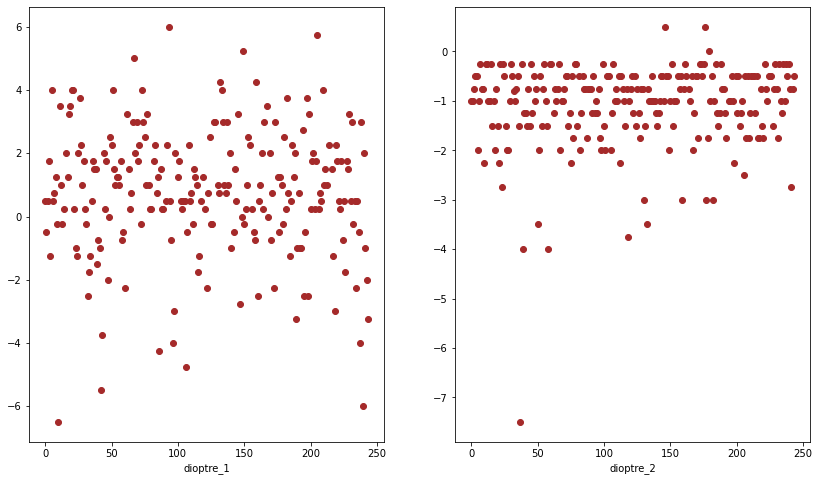

In [18]:
scatter_plot_columns(od, ['dioptre_1','dioptre_2'])

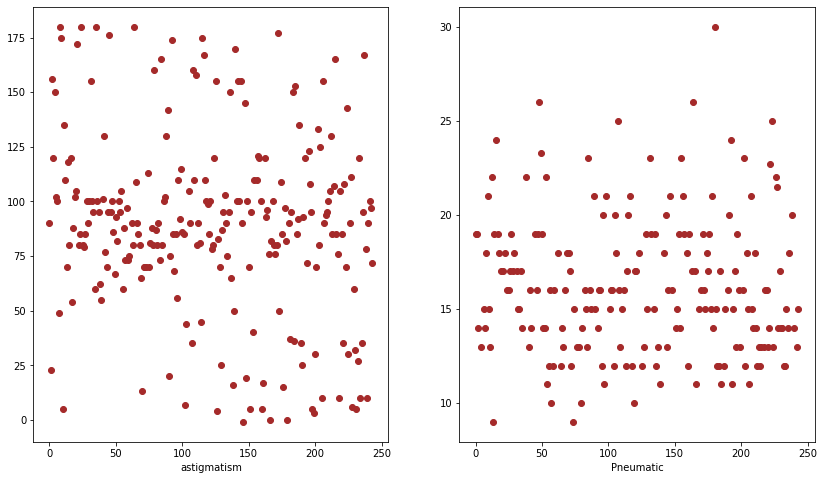

In [19]:
scatter_plot_columns(od, ['astigmatism', 'Pneumatic'])

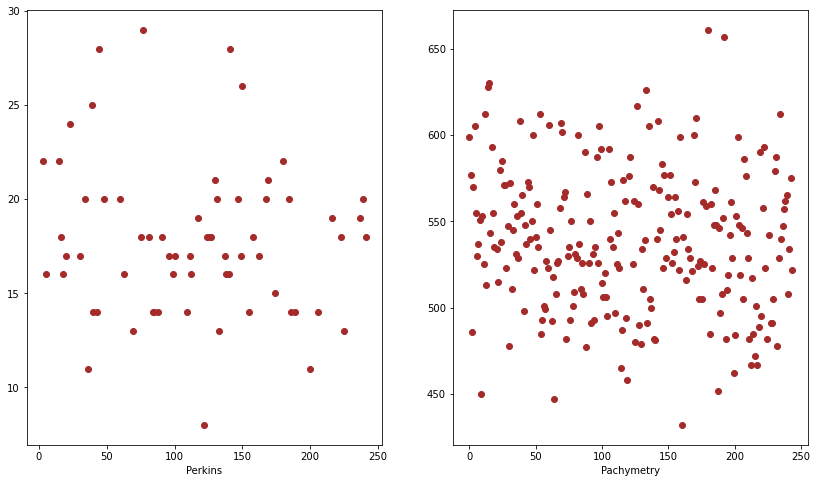

In [20]:
scatter_plot_columns(od, ['Perkins','Pachymetry'])

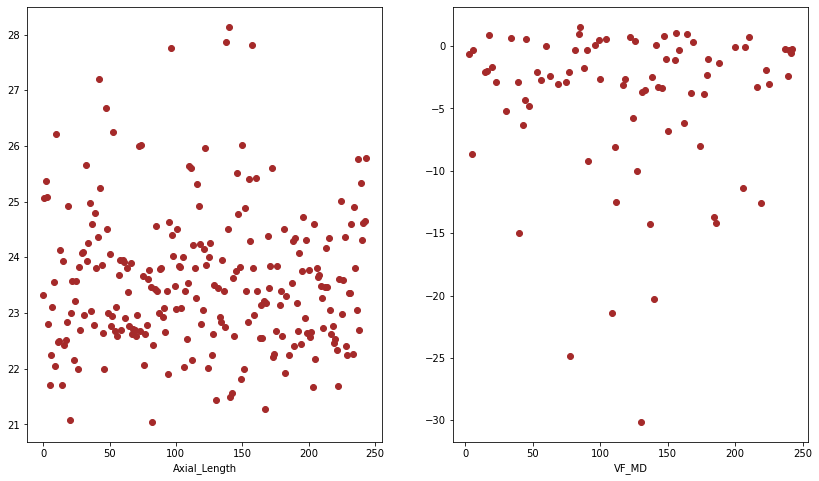

In [21]:
scatter_plot_columns(od, ['Axial_Length', 'VF_MD'])

Now we will use histograms to show the distribution and see if any of the columns have a normal distribution 


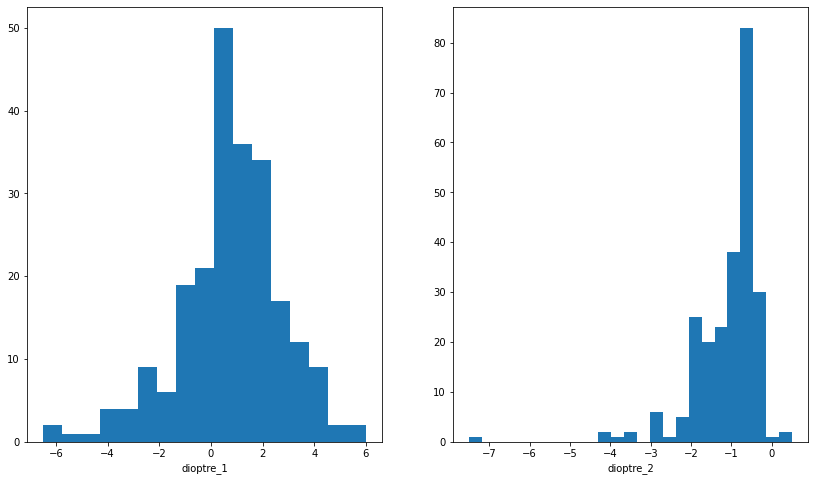

In [22]:
def histogram_for_columns(df, ids):
    if len(ids)==1:
        plt.hist(df[ids[0]], bins='auto')
        
        plt.show()
        return
    fig, ax = plt.subplots(1, len(ids), figsize=(14, 8))
    
    for i in range(len(ids)):
        ax[i].hist(df[ids[i]], bins='auto')
        ax[i].set_xlabel(ids[i])

histogram_for_columns(od, ['dioptre_1','dioptre_2'])

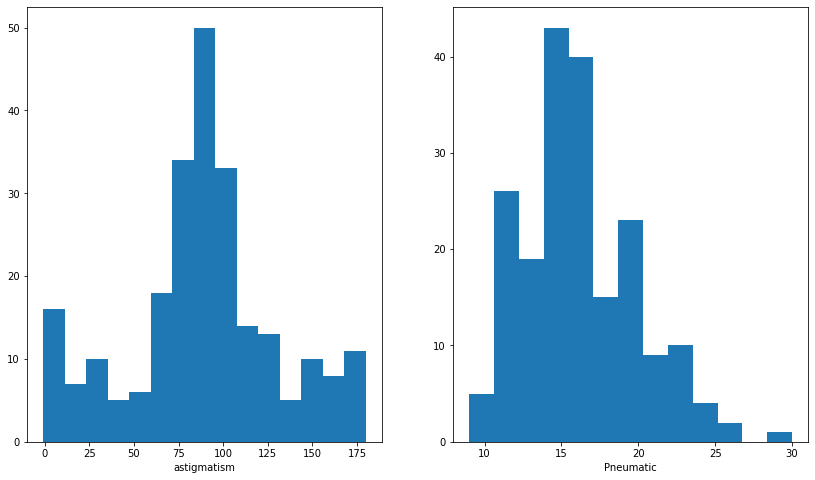

In [23]:
histogram_for_columns(od, ['astigmatism', 'Pneumatic'])

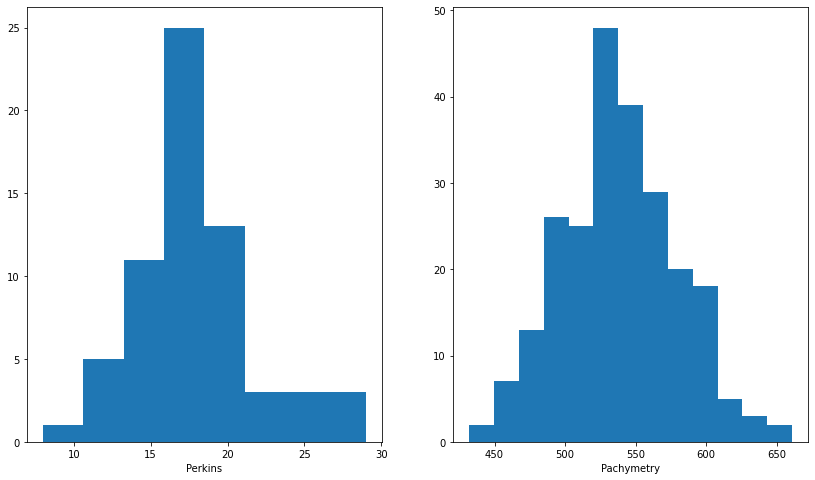

In [24]:
histogram_for_columns(od, ['Perkins','Pachymetry'])

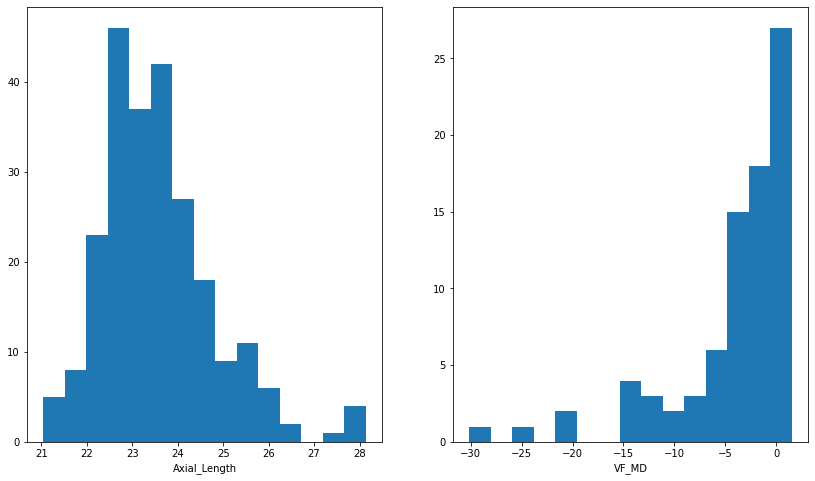

In [25]:
histogram_for_columns(od, ['Axial_Length', 'VF_MD'])

as we can see some of these have normal distributions we will use the interquartile ranges to remove outliers from the columns let's confirm these are normally distributed with the pandas.skew()

In [26]:
for i in ['Pachymetry','Perkins', 'astigmatism', 'dioptre_1']:
    print(f'skew of {i} is {od[i].skew()}')

skew of Pachymetry is 0.17552035854868572
skew of Perkins is 0.6444499170784165
skew of astigmatism is -0.030395542138215725
skew of dioptre_1 is -0.5535115947042473


this confirms pchymetry and astigmatism are normally distributed without skew

Now we will check for the relationships of thee data between eachother
we will do this by checking the correlation of vaariables 

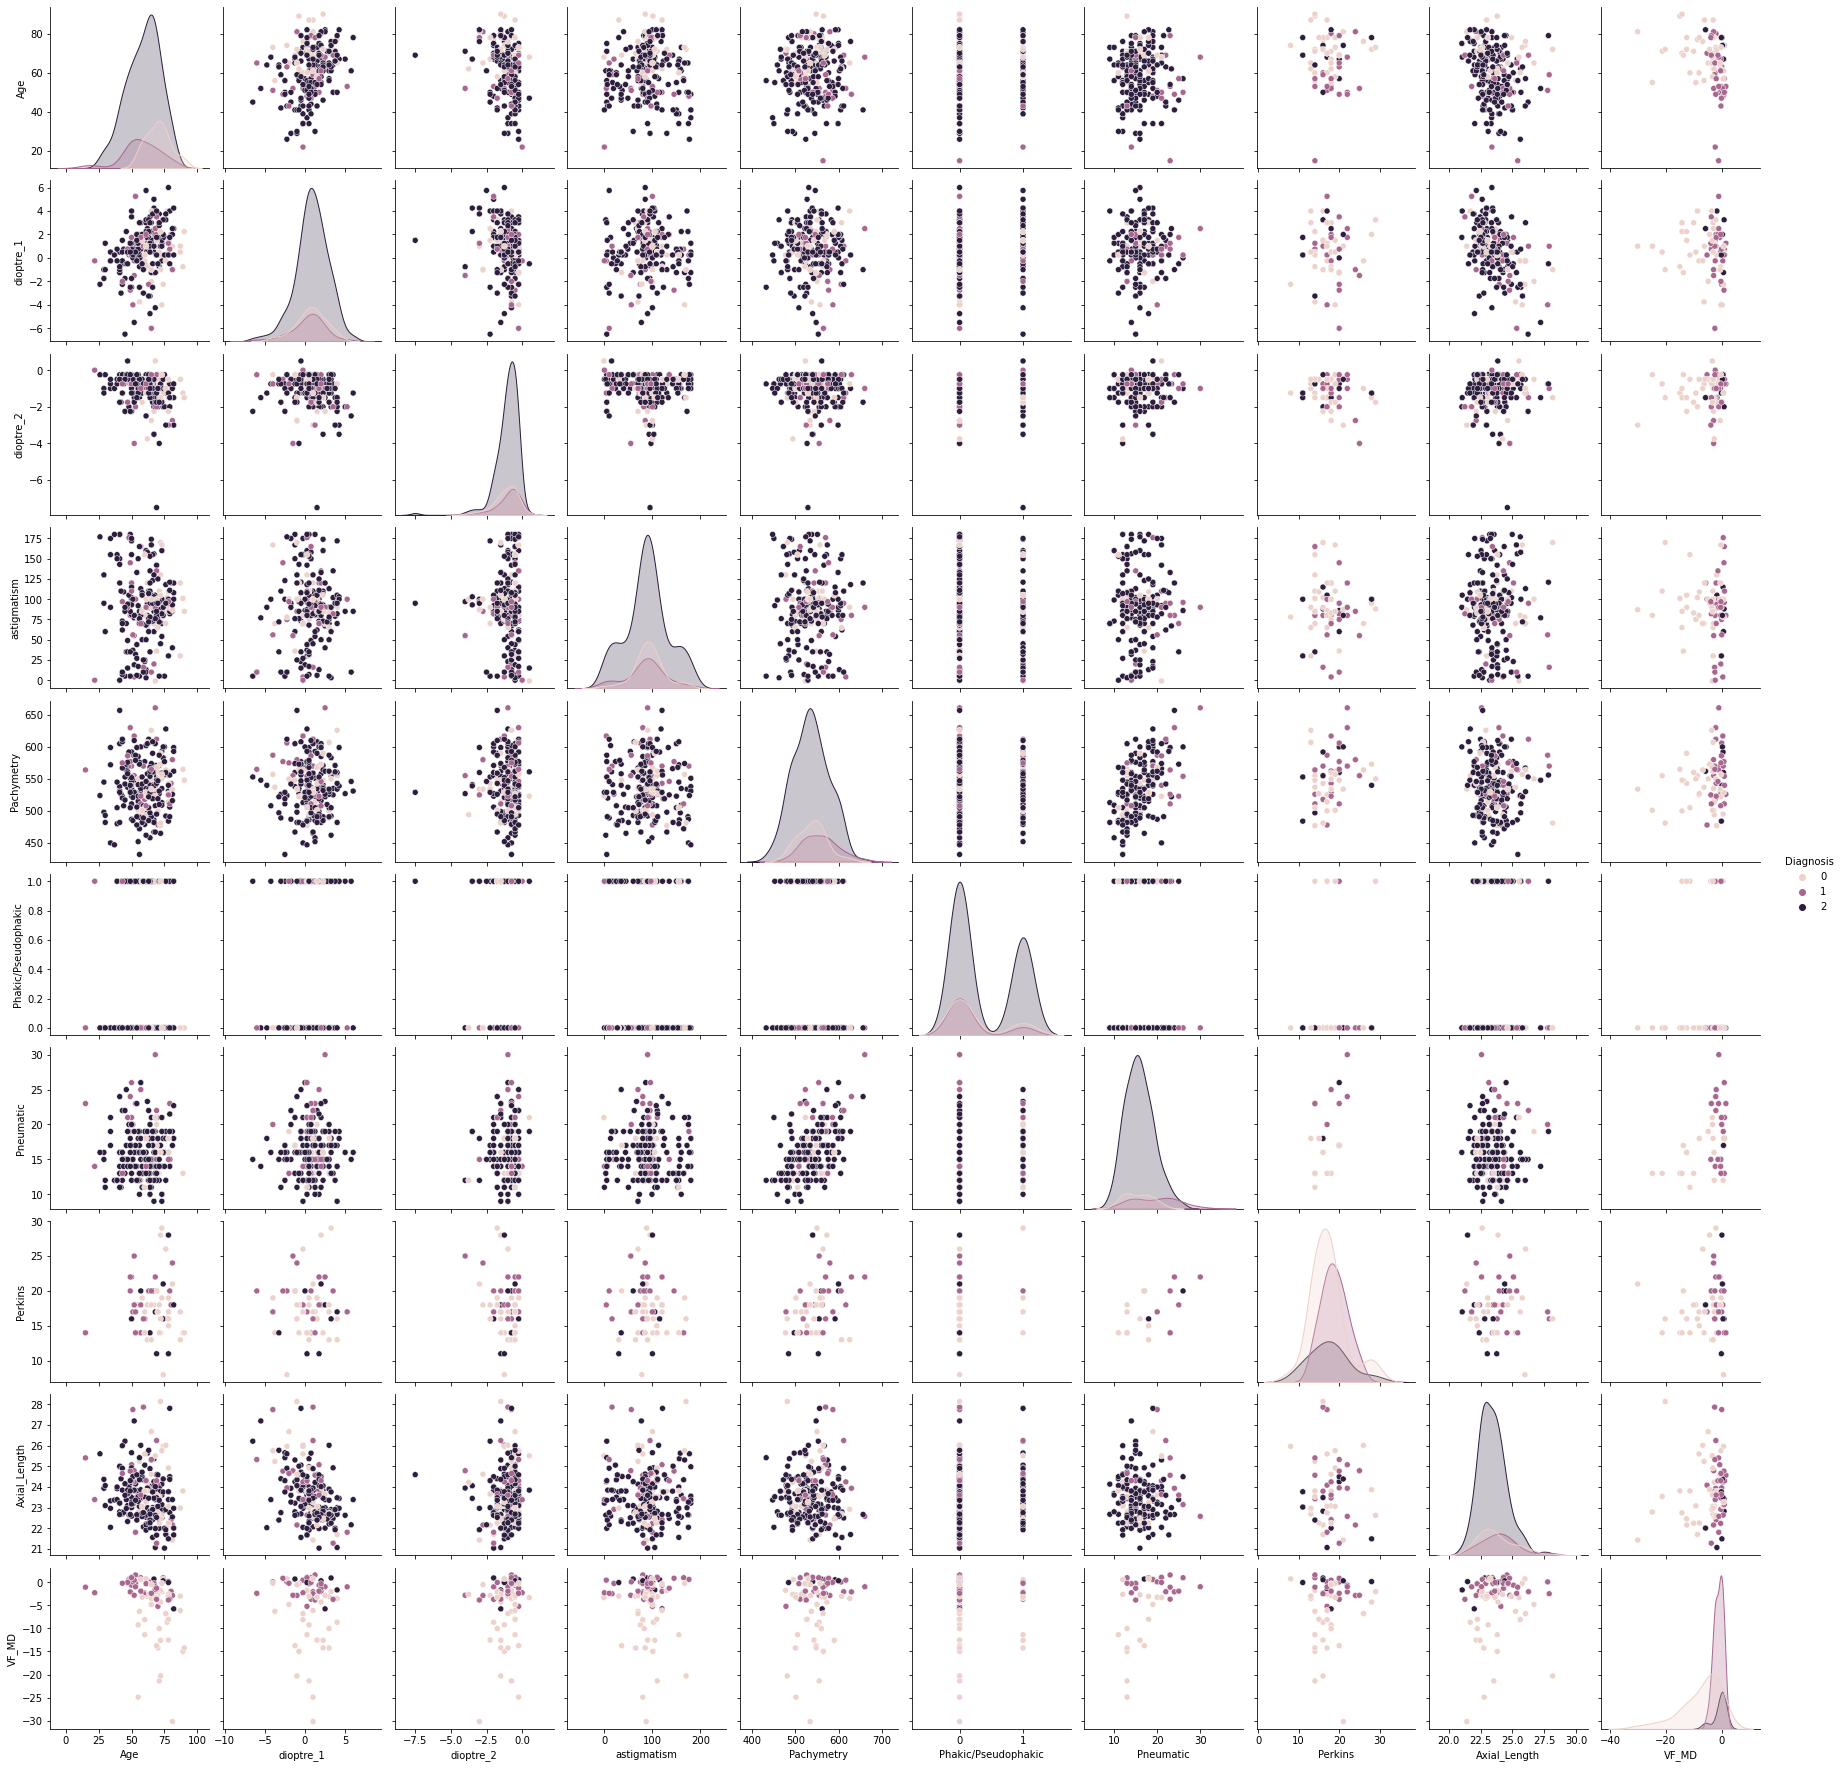

In [27]:
sns.pairplot(od, hue="Diagnosis")

<AxesSubplot:>

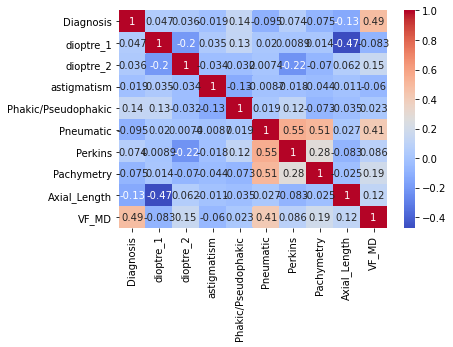

In [28]:
sns.heatmap(od.loc[:,['Diagnosis','dioptre_1', 'dioptre_2','astigmatism','Phakic/Pseudophakic', 'Pneumatic', 'Perkins',
       'Pachymetry', 'Axial_Length', 'VF_MD']].corr(), annot= True, cmap= 'coolwarm')

no real correlation with a slight negative with axial length and dioptre_1 and a slight positive with pneumatic and VF_MD, pachymetric, and perkins

/Users/curranmaguire/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret value `VF_MD` for parameter `y`

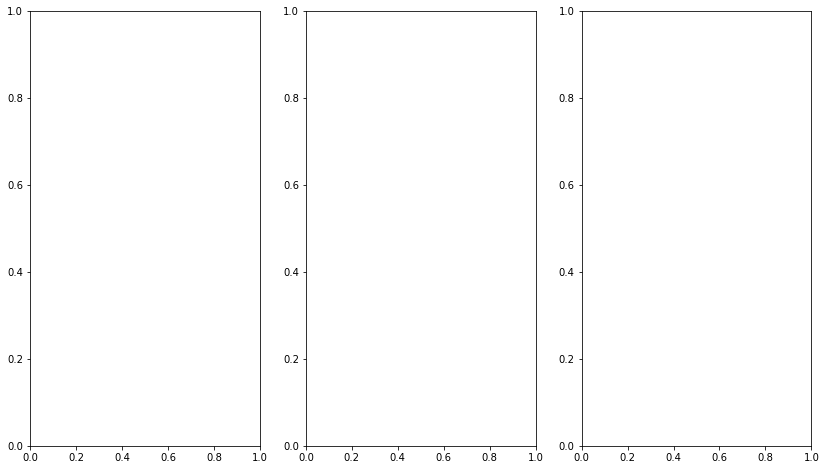

In [29]:
ids = ['VF_MD', 'Pachymetry', 'Perkins']
x=np.arange(0,len(od[ids[0]]))
fig, ax = plt.subplots(1, len(ids), figsize=(14, 8))

for i in range(len(ids)):
    sns.scatterplot(od, x= 'Pneumatic', y=ids[i], ax=ax[i])
    




<AxesSubplot: xlabel='Axial_Length', ylabel='dioptre_1'>

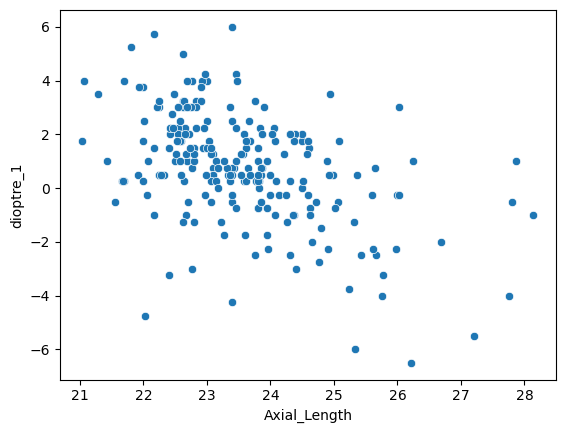

In [ ]:
sns.scatterplot(od, x= 'Axial_Length', y='dioptre_1')

<AxesSubplot: xlabel='VF_MD', ylabel='Diagnosis'>

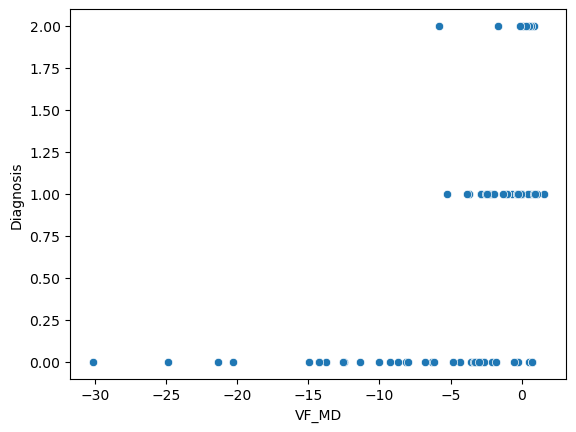

In [ ]:
sns.scatterplot(od, x='VF_MD', y='Diagnosis')

as we can see there is no real correlation with variables

as pneumatics and perkins are both measures of the same thing. they also have a sleight correlation of 0.55

------------------------------------------------Missing Completely At Random Checks-----------------------------------

here we need to check if the values that have been removed from the dataset's are missing completely at random so that we can descide on which methods we will use to replace missing values in the datasets


In [ ]:
def mcar_test_(df):
    # select column of interest
    for i in df.columns:

        col = df[i]

        # check if column is MCAR
        missing_mask = col.isna()
        prop_missing = missing_mask.sum() / len(col)
        if prop_missing == np.mean(missing_mask):
            print(f'The column {i} is MCAR.')
        else:
            print(f'The column {i} is not MCAR.')
mcar_test_(od)

The column ID is MCAR.
The column Age is MCAR.
The column Gender is MCAR.
The column Diagnosis is MCAR.
The column dioptre_1 is MCAR.
The column dioptre_2 is MCAR.
The column astigmatism is MCAR.
The column Pachymetry is MCAR.
The column Phakic/Pseudophakic is MCAR.
The column Pneumatic is MCAR.
The column Perkins is MCAR.
The column Axial_Length is MCAR.
The column VF_MD is MCAR.


----------------------------------------------------outlier detection techniques-------------------------------------------------

detect with the inter quartile ranges and then replace the data with NAN

In [ ]:
missing_data_counter(od)
def detect_outliers (df,ids):
    for id in ids:

        Q1 = df[id].quantile(0.25)
        Q3 = df[id].quantile(0.75)
        IQR = Q3 - Q1
        #as this is a small dataset and we don't want to remove too many values we will increase the IQR multiplier to make the outlier ranges more leanient
        outliers = df[id][(df[id] < Q1 - 2.5*IQR) | (df[id] > Q3 + 2.5*IQR)]
        for i in outliers:
            
            df[id].replace(i, np.nan, inplace=True)

detect_outliers(od, ['dioptre_1', 'dioptre_2', 'Pneumatic',
        'Axial_Length'])
missing_data_counter(od)

ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 6.147540983606557
dioptre_2's percentage of missing values is: 1.639344262295082
astigmatism's percentage of missing values is: 1.639344262295082
Pachymetry's percentage of missing values is: 2.8688524590163933
Phakic/Pseudophakic's percentage of missing values is: 2.0491803278688523
Pneumatic's percentage of missing values is: 19.262295081967213
Perkins's percentage of missing values is: 73.77049180327869
Axial_Length's percentage of missing values is: 2.0491803278688523
VF_MD's percentage of missing values is: 66.39344262295081



ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 6.967213114

as we can see astigmatism and pachymetry are normally distributed.

In [ ]:
#let's make the upper and lower limits of the Z-score anything outside of these ranges will be removed.
def Z_score_outlier_removal(df,id):
    upper_limit = df[id].mean() + 3*df[id].std()
    lower_limit = df[id].mean() - 3*df[id].std()
    print(f'upper limit is {upper_limit}')
    print(f'lower limit is {lower_limit}')
    outliers = df[id][(df[id] < lower_limit) | (df[id] > upper_limit)]
    print(outliers)
    for i in outliers:
        df[id].replace(i, np.nan, inplace=True)
for i in ['astigmatism', 'Pachymetry']:
    Z_score_outlier_removal(od, i)

upper limit is 214.88959062212814
lower limit is -37.21459062212814
Series([], Name: astigmatism, dtype: float64)
upper limit is 661.670549858498
lower limit is 415.62902820057377
Series([], Name: Pachymetry, dtype: float64)


As we ccan see from Z score neither of these distributions have outliers


-------------------------------------------------filling in missing variables-----------------------------------------------

let's start with out MCAR columns here we can use mean imputation to fill in the values as they are missing completely at random however looking at the histogram's we will need to use mode and median values as they have skews

In [ ]:
missing_data_counter(od)
def normal_mcar_fill(df, ids):
    for i in ids:
        df[i].fillna(df[i].mean(), inplace=True)

normal_mcar_fill(od, ['astigmatism', 'Pachymetry'])
missing_data_counter(od)

ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 6.967213114754098
dioptre_2's percentage of missing values is: 2.0491803278688523
astigmatism's percentage of missing values is: 1.639344262295082
Pachymetry's percentage of missing values is: 2.8688524590163933
Phakic/Pseudophakic's percentage of missing values is: 2.0491803278688523
Pneumatic's percentage of missing values is: 19.262295081967213
Perkins's percentage of missing values is: 73.77049180327869
Axial_Length's percentage of missing values is: 2.459016393442623
VF_MD's percentage of missing values is: 66.39344262295081



ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 6.967213114

now we will deal with the skewed data I am going to use the median as this is a better representation of the skewed data then the mean


In [ ]:
missing_data_counter(od)
def skewed_mcar_fill(df,ids):
    for i in ids:
        df[i].fillna(df[i].median(), inplace=True)
skewed_mcar_fill(od, ['dioptre_1', 'dioptre_2', 'Pneumatic', 
        'Axial_Length'])
missing_data_counter(od)

ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 6.967213114754098
dioptre_2's percentage of missing values is: 2.0491803278688523
astigmatism's percentage of missing values is: 0.0
Pachymetry's percentage of missing values is: 0.0
Phakic/Pseudophakic's percentage of missing values is: 2.0491803278688523
Pneumatic's percentage of missing values is: 19.262295081967213
Perkins's percentage of missing values is: 73.77049180327869
Axial_Length's percentage of missing values is: 2.459016393442623
VF_MD's percentage of missing values is: 66.39344262295081



ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 0.0
dioptre_2's percentage of missing va

as Phakic/pseudophakic has a missing value % that is quite low and it is a discrete variable we will use the most common imputation to fill in the missing values

In [ ]:
def mode_missing_data_fill(df, id):
    df[id].fillna(df[id].mode, inplace=True)

mode_missing_data_fill(od, 'Phakic/Pseudophakic')
missing_data_counter(od)

ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 0.0
dioptre_2's percentage of missing values is: 0.0
astigmatism's percentage of missing values is: 0.0
Pachymetry's percentage of missing values is: 0.0
Phakic/Pseudophakic's percentage of missing values is: 0.0
Pneumatic's percentage of missing values is: 0.0
Perkins's percentage of missing values is: 73.77049180327869
Axial_Length's percentage of missing values is: 0.0
VF_MD's percentage of missing values is: 66.39344262295081





dropping high missing value items


In [ ]:

print(od.columns)
od.drop('VF_MD', axis= 1)

Index(['ID', 'Age', 'Gender', 'Diagnosis', 'dioptre_1', 'dioptre_2',
       'astigmatism', 'Pachymetry', 'Phakic/Pseudophakic', 'Pneumatic',
       'Perkins', 'Axial_Length', 'VF_MD'],
      dtype='object')


,ID,Age,Gender,Diagnosis,dioptre_1,dioptre_2,astigmatism,Pachymetry,Phakic/Pseudophakic,Pneumatic,Perkins,Axial_Length
0,#038,34,female,2,0.50,-1.00,90.0,599.0,NaN,19.0,NaN,23.33
1,#280,60,male,2,-0.50,-1.00,23.0,577.0,1.0,19.0,NaN,25.06
2,#198,67,male,2,0.50,-0.75,156.0,486.0,0.0,14.0,NaN,25.37
3,#041,50,female,1,1.75,-0.50,120.0,570.0,0.0,NaN,22.0,25.08
4,#271,41,male,2,-1.25,-0.50,150.0,605.0,0.0,13.0,NaN,22.80
...,...,...,...,...,...,...,...,...,...,...,...,...
239,#089,65,female,1,-6.00,-0.25,10.0,565.0,0.0,NaN,20.0,25.33
240,#264,61,male,1,2.00,-0.75,90.0,508.0,0.0,14.0,NaN,24.31
241,#056,65,male,0,-1.00,-2.75,100.0,534.0,0.0,NaN,18.0,24.62
242,#018,43,male,1,-2.00,-0.75,97.0,575.0,1.0,13.0,NaN,24.66
